## Data analysis - extracting Ca2+ signals from real data:

In this notebook I extract CA2+ fluorescent signals by using predefined masks, estimating the signal noise ratio and also smoothing and detecting events on the extracted signals. Fluorescent liquid GCaMP8 was previously injected to the rats brain by a professional and during a spatial task the GCaMP (which conects to CA2+) acitivty is observable due to its visible, fluorescent activity - since GCaMP connects to calcium we can assume that it roughly represent the intra and extracellular outflows that is equal in this sense with the neural events of somas and denrites (membrane potential changes). The microscope recorded the CA3 region (pyramidal neurons). The original data consits 512 x 512 pixels and 1000 frames. In this notebook due to limited computational capacitiy using only one slice of this tensor data which is about 1000 timebins. The whole data is a 15 minutes recording made by a specialist using a two photon microscope. The observed slice of sequnce consints of 1000 bins, so it is estimately 1.5 minutes long (8.8 Hz).

In [1]:
#packages
import numpy as np
import sys
import os
import shapely

from matplotlib import pyplot as plt
from shapely.geometry.polygon import Polygon

The next function was created By Balazs Luko (Neuronal Signaling research group - IEOM). I use this function to plot the mean image of the recording just for visual transparency. Balazs is also created the ROIs that I will use. It is important to note that the following data has gone through a motion correction process in the Suite2p program used by Balazs, wherein the ROi masks were also created and added.

In [2]:
def plane0_ROIs_drawn(suite2p_folder, cell, numbers, add_points=None):
    masks0 = np.load(suite2p_folder + '/plane0/'+ str(cell) + '/masks.npy', allow_pickle=True)
    img0 = np.load(suite2p_folder + '/plane0/mean_img.npy', allow_pickle=True)
    polygons0 =  np.load(suite2p_folder + '/plane0/' + str(cell) + '/polygons.npy', allow_pickle=True)
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    # plane0
    fig0, ax2 = plt.subplots()
    ax2.matshow(img0)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    for i in range(polygons0.shape[0]):
        if len(colors)<=i:
            color=colors[i%len(colors)]
        else:
            color=colors[i]
            
        poly_points = polygons0[i]
        polygon_shape = Polygon(poly_points)
        ax2.plot(*polygon_shape.exterior.xy)
        
        if numbers:
            x = np.mean(masks0[i][:,1])
            y = np.mean(masks0[i][:,0])
            ax2.text(x,y,str(i),size=15, color = color, style = 'italic')
            
        if (add_points is not None):
            ax2.scatter(add_points[0,:], add_points[1,:], color="white", marker="+")

Define the default folder and the needed parameters.

In [3]:
suite2p_folder = 'C:/Users/Tóth Mátyás/Desktop/szakdolgozat/example_dendriric recording_numpy'
cell = 'c1'
numbers = [0,1,2,3,4,5,6]

In [4]:
imgs = np.load('C:/Users/Tóth Mátyás/Desktop/szakdolgozat/example_dendriric recording_numpy/plane0/0.npy') # The last parameter is the number of the acutal sequence.
roi_masks = np.load('C:/Users/Tóth Mátyás/Desktop/szakdolgozat/example_dendriric recording_numpy/c1/masks.npy', allow_pickle = True)

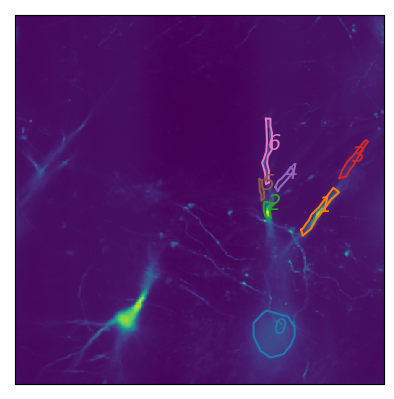

In [5]:
plane0_ROIs_drawn(suite2p_folder,cell,numbers)

Checking the data shape and the masks shapes (important for setting the same pixel ranges on the generated dataset).

In [25]:
np.shape(imgs)

(1000, 512, 512)

In [26]:
print(np.shape(roi_masks[0]))

(2744, 2)


In [27]:
for i in np.arange(7):
    print(roi_masks[i].shape)

(2744, 2)
(609, 2)
(185, 2)
(422, 2)
(229, 2)
(113, 2)
(541, 2)


imgs: tensor contains the data

The following lines of code and the ROI function simply takes the number of masks as an argument and using a for loop to extract the every spatial region (masks) on every frame (1000). After this I add these mask frames to a zero array (has the same length as the imgs tensor). This new signal then needs to be divided by the number of masks, so a signal belonging to specific mask can be further processed now.

Text(0, 0.5, 'Signal amplitude')

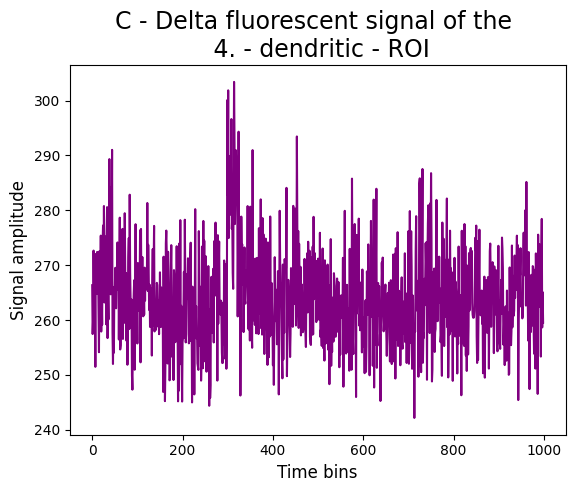

In [31]:
i_mask = 4
mask = roi_masks[i_mask]
L_mask = len(mask)
signal = np.zeros(imgs.shape[0])
for i_pixel in np.arange(L_mask):
    pix = mask[i_pixel]
    signal = signal + imgs[:,pix[0], pix[1]]
signal = signal / L_mask

plt.plot(signal[1:1000], 'purple')
plt.title('C - Delta fluorescent signal of the \n 4. - dendritic - ROI', fontsize = 17)
plt.xlabel('Time bins', fontsize = 12)
plt.ylabel('Signal amplitude', fontsize = 12)

In [33]:
# Extracting DFpF amplitude, maximal amplitude and standard deviation of the signals

df_sigs = []
dfpf_sigs = []
DFpF_amps = np.zeros(7)
DF_amps = np.zeros(7)
for i in range(7):
    sig, dfpf, ampl_df, ampl_dfpf, SD_sig = ROI(i)
    DF_amps[i] = ampl_df
    DFpF_amps[i] = ampl_dfpf 
    df_sigs.append(sig)
    dfpf_sigs.append(dfpf)

352.9116253644315
522.3669950738916
790.2567567567568
285.03554502369667
263.5829694323144
271.5132743362832
322.2513863216266


The ROI function itself not onyl extracting the signal, but it also returnes the max amplitude of each signal (maximum(signal) - median(signal)) and returnes the signal with the same basline power (DFpF) of each signal and its maximum and standard deviation - max(signal- median(signal)) - 1.

In [32]:
def ROI(mask_number):  
    i_number = mask_number # mask numbers
    tensor = imgs.copy() # tensor
    rois = roi_masks.copy() # rois_masks
    mask_rois = rois[i_number] # list of roi masks
    len_mask_rois = len(mask_rois) # lenght of the roi masks list
    signal_F = np.zeros(imgs.shape[0]) # empty tensor with the shape of original neuronal data
    for k in np.arange(len_mask_rois): 
        pix_rois = mask_rois[k] # mask pixels
        signal_F = signal_F + imgs[:,pix_rois[0], pix_rois[1]] # extracting mask pixels and placing them on the neuronal data
    signal_F = signal_F / len_mask_rois # extracting the mean of the pixels in a specific roi - Fluorescent signal
    DF = signal_F.copy()
    signal_max_amp = max(signal_F) - np.median(signal_F) # measuring the maximal signal amplitude
    DFpF = (signal_F - np.median(signal_F)) / np.median(signal_F)#DFpF
    ampl_DFpF = max(DFpF) -1 # DFpF amplitude with the same baseline 0
    print(np.median(signal_F))
    return DF, DFpF, signal_max_amp, ampl_DFpF, np.std(DFpF)

In [34]:
print(DF_amps)
print(DFpF_amps)

[117.61825802 496.66091954 910.82972973  81.78909953  39.81877729
 103.57522124 307.4232902 ]
[-0.66672036 -0.04921076  0.15257443 -0.71305649 -0.84893266 -0.61852612
 -0.04601406]


In [35]:
print(np.mean(DF_amps))
print(np.mean(DFpF_amps))

293.9593279354801
-0.39855514788714635


For visual transparency I plot the DFpF signals.

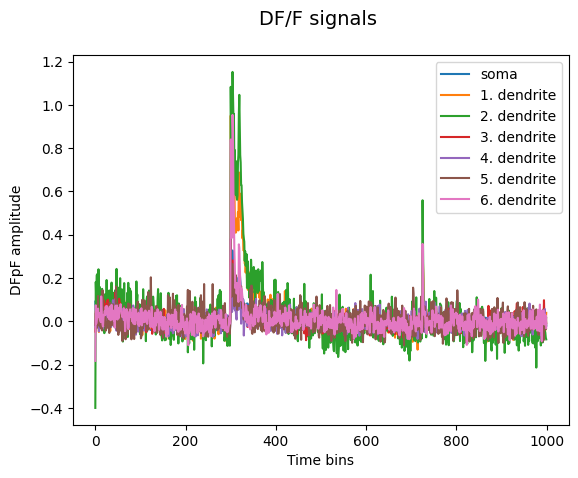

In [38]:
fig0, ax0 = plt.subplots()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i in range(7):
    plt.plot(dfpf_sigs[i], color=colors[i])
    plt.title('DF/F signals \n', fontsize = 14)
    plt.xlabel('Time bins', fontsize = 10)
    plt.ylabel('DFpF amplitude', fontsize = 10)
    plt.legend(['soma','1. dendrite', '2. dendrite', '3. dendrite', '4. dendrite', '5. dendrite', '6. dendrite'])

## Data analysis - mesuring the standard deviation and the SNR on real data:

In the next cell, I extract random pixels (100) from noise area then take their standard deviation and mean. These are the parameters that I need to appproach when I make the same calculations on synthetic data.

In [161]:
M = 100
noise_m_and_std = np.zeros((2, M))
noise_ij = np.zeros((2, M))
for m in np.arange(M):
    i = np.random.randint(200) + 100
    j = np.random.randint(200)
    noise_m_and_std[0,m] = np.mean(imgs[:,i,j])
    noise_m_and_std[1,m] = np.std(imgs[:,i,j])
    noise_ij[:,m] = [i,j]

Density of noise signals:

Text(0, 0.5, 'Estimated number of standard deviation values')

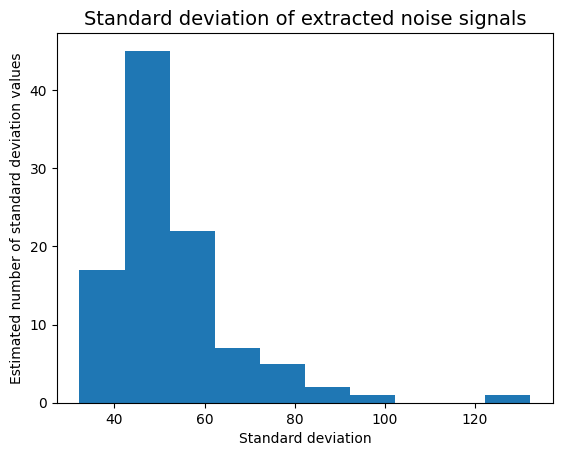

In [162]:
plt.hist(noise_m_and_std[1])
plt.title('Standard deviation of extracted noise signals', fontsize = 14)
plt.xlabel('Standard deviation')
plt.ylabel('Estimated number of standard deviation values')

In [163]:
print(np.mean(noise_m_and_std, axis=1))

[250.74054     53.23033766]


The average standard devation of noise is: 52
The average mean of noise is: 240

Next, I measure the snr by dividing the average standard deviation of delta fluorescent signals by the average of the previoulsy measured standard feviation of 100 noise pixels.

In [164]:
df_std = np.std(df_sigs)
noise_m_and_s_var = np.mean(noise_m_and_std, axis=1)
noise_std = noise_m_and_s_var[1]
df_snr = df_std/noise_std
df_snr

4.891177863344959

The signal noise ratio is: 3.4

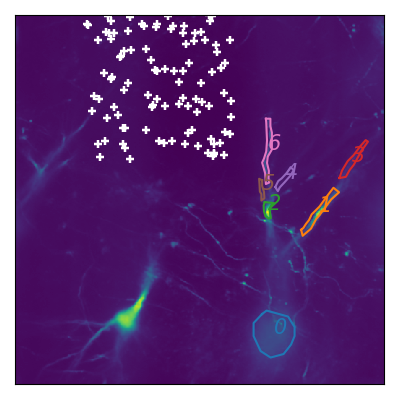

In [165]:
plane0_ROIs_drawn(suite2p_folder,cell,numbers, noise_ij)

In the next code cell I measured the standard error of the population mean that means the group of pixels in every ROI (7). By definiton standard error measures that how good of an estimator is the given sample mean of the total population's mean. In our case, If I take 100 random pixels from a noisy area and measure the average standard deviation of these pixels (along the 1000 long sequence) the SE is roughly 50. Since we are using a value that is the standard deviation of random, independent (major conditions) samples, we can further use this value for calculating the standard error of a ROI or the expected standard deviation of each ROI. Another important conditons for using this estimator are: 1. sample size n must begreater than 30 (given by the central limit theorem), 2. n <= 10% of population size. In our case the sample is 100, which is smaller than the 10% of total population (512 x 512 = 262144).

For comparison, I calculated the standard deviation of every fluorescent signal from 790:990. As we see these values are multiple times bigger than the standard error values. By calulating these values my goal was to provide mathematical parameters for correctly creating synthetic noise on the generated data set. It is important to note that the growing population size n -> p (population size) always result in lower standard deviation values.

Standard error:

\begin{align}
        SE = \frac{\sigma}{\sqrt{N}}
    \end{align}

In [166]:
sigsA = np.array(df_sigs)

expSD = np.zeros(7)
for i in np.arange(7):
    N = len(roi_masks[i])
    expSD[i] = 56 / np.sqrt(N)
print(np.std(sigsA[:,790:990], axis=1))
print(expSD)

[27.18841651 27.78788955 58.79602714  7.44587047  7.69155066 14.55753434
  9.03323702]
[1.06904497 2.26923452 4.11720188 2.72603735 3.70058416 5.26803686
 2.40762805]


Text(0, 0.5, 'Amplitude')

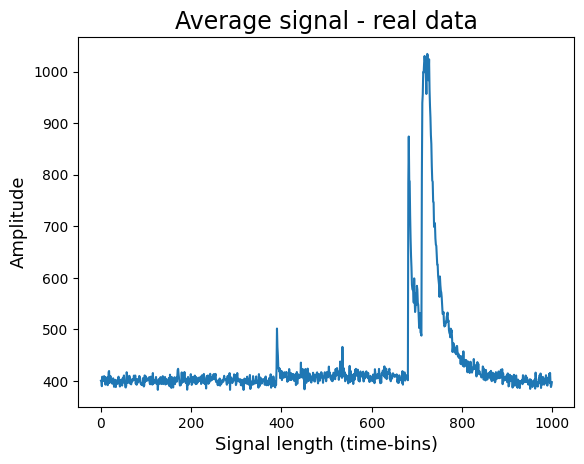

In [167]:
sigs_avg = (df_sigs[0] + df_sigs[1] + df_sigs[2] + df_sigs[3] + df_sigs[4] + df_sigs[5] + df_sigs[6])/7

plt.plot(sigs_avg)
plt.title('Average signal - real data', fontsize = 17)
plt.xlabel('Signal length (time-bins)', fontsize = 13)
plt.ylabel('Amplitude', fontsize = 13)

## Data analysis - Gauss smoothing on real data:

In order to keep the original shape of the signals I needed to implement a function that adds the first and the last values of the original data array to the begining and to the end of the array in a range that is always the half and minus 1 long to a given N (odd) length convolution kernel. 

In [168]:
def preprocess_for_conv(signal_for_gauss, kernel_length):
    N = len(signal_for_gauss)
    if (kernel_length % 2) == 0:
        return ('Kernel length is even.')
    K = int((kernel_length - 1)/2) # must be even in order to have the target data point at the middle
    empty = np.zeros(N + 2*K) 
    signal_start = signal_for_gauss[0]
    signal_end = signal_for_gauss[-1]
    empty[0:K] =  signal_start
    empty[-K:] = signal_end
    empty[K:(N+K)] = signal_for_gauss
    return empty

In [169]:
signal1_prep = preprocess_for_conv(dfpf_sigs[0], 15)
signal2_prep = preprocess_for_conv(dfpf_sigs[1], 15)
signal3_prep = preprocess_for_conv(dfpf_sigs[2], 15)
signal4_prep = preprocess_for_conv(dfpf_sigs[3], 15)
signal5_prep = preprocess_for_conv(dfpf_sigs[4], 15)
signal6_prep = preprocess_for_conv(dfpf_sigs[5], 15)
signal7_prep = preprocess_for_conv(dfpf_sigs[6], 15)

Defining a 15 length Gauss kernel. 

Gauss-kernel: 

\begin{align}
        g(x) = \frac{1}{\sqrt{2\pi\sigma}} * exp^{-x^2/(2\sigma^2)}
    \end{align}

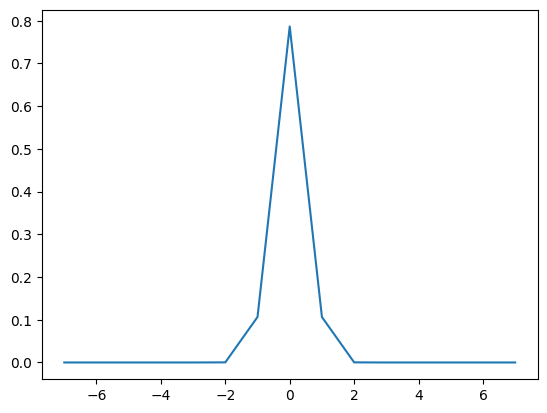

In [170]:
# 16 long gauss convolutional kernel - identical with the kernel I applied on synthetic data:

x = np.arange(-7,8,1)
sigma = 0.5
normal = 1 / (2.0 * np.pi * sigma**2)
gauss_kernel_beta =  np.exp(-((x**2) / (2.0*sigma**2))) * normal
gauss_kernel = gauss_kernel_beta / np.sum(gauss_kernel_beta)
plt.plot(x,gauss_kernel)

## Data analysis - Event detection on real data:

Using the same event detection algorithm that I introduced during synthetic data generation.

In [171]:
def event_detector(signal, theta_upper = 1.65, theta_lower = 1.6): 
    
    N = len(signal)
    
    event = np.zeros(N)
    transient = np.zeros(N)
    start_end = []
    
    refr = 0
    start_end_i = np.zeros(2)
    
    for i in np.arange(1,N):
        if ((signal[i] > theta_upper) and (signal[i-1] < theta_upper) and (refr == 0)):
            event[i] = 1 
            refr = 1
            start_end_i[0] = i
        if ((signal[i]<theta_lower) and (signal[i-1] > theta_lower) and (refr == 1)):
            refr = 0
            start_end_i[1] = i
            start_end.append(start_end_i)
            start_end_i = np.zeros(2)
        if (refr == 1):
            transient[i] = 1
    if ((start_end_i[0] > 0) & (start_end_i[1] == 0)):
        start_end_i[1] = N
        start_end.append(start_end_i)
    
    return event

Smoothing the signals and detecting events:

In [172]:
signal1_smooth = np.convolve(signal1_prep, gauss_kernel, mode='valid')
signal2_smooth = np.convolve(signal2_prep, gauss_kernel, mode='valid')
signal3_smooth = np.convolve(signal3_prep, gauss_kernel, mode='valid')
signal4_smooth = np.convolve(signal4_prep, gauss_kernel, mode='valid')
signal5_smooth = np.convolve(signal5_prep, gauss_kernel, mode='valid')
signal6_smooth = np.convolve(signal6_prep, gauss_kernel, mode='valid')
signal7_smooth = np.convolve(signal7_prep, gauss_kernel, mode='valid')

sig1_event = event_detector(signal1_smooth, 0.05, 0.007) 
sig2_event = event_detector(signal2_smooth, 0.12, 0.01)
sig3_event = event_detector(signal3_smooth, 0.2, 0.007) 
sig4_event = event_detector(signal4_smooth, 0.2, 0.007) 
sig5_event = event_detector(signal5_smooth, 0.12, 0.001)
sig6_event = event_detector(signal6_smooth, 0.2, 0.005)
sig7_event = event_detector(signal7_smooth, 0.1, 0.005)

Plot the detected events:

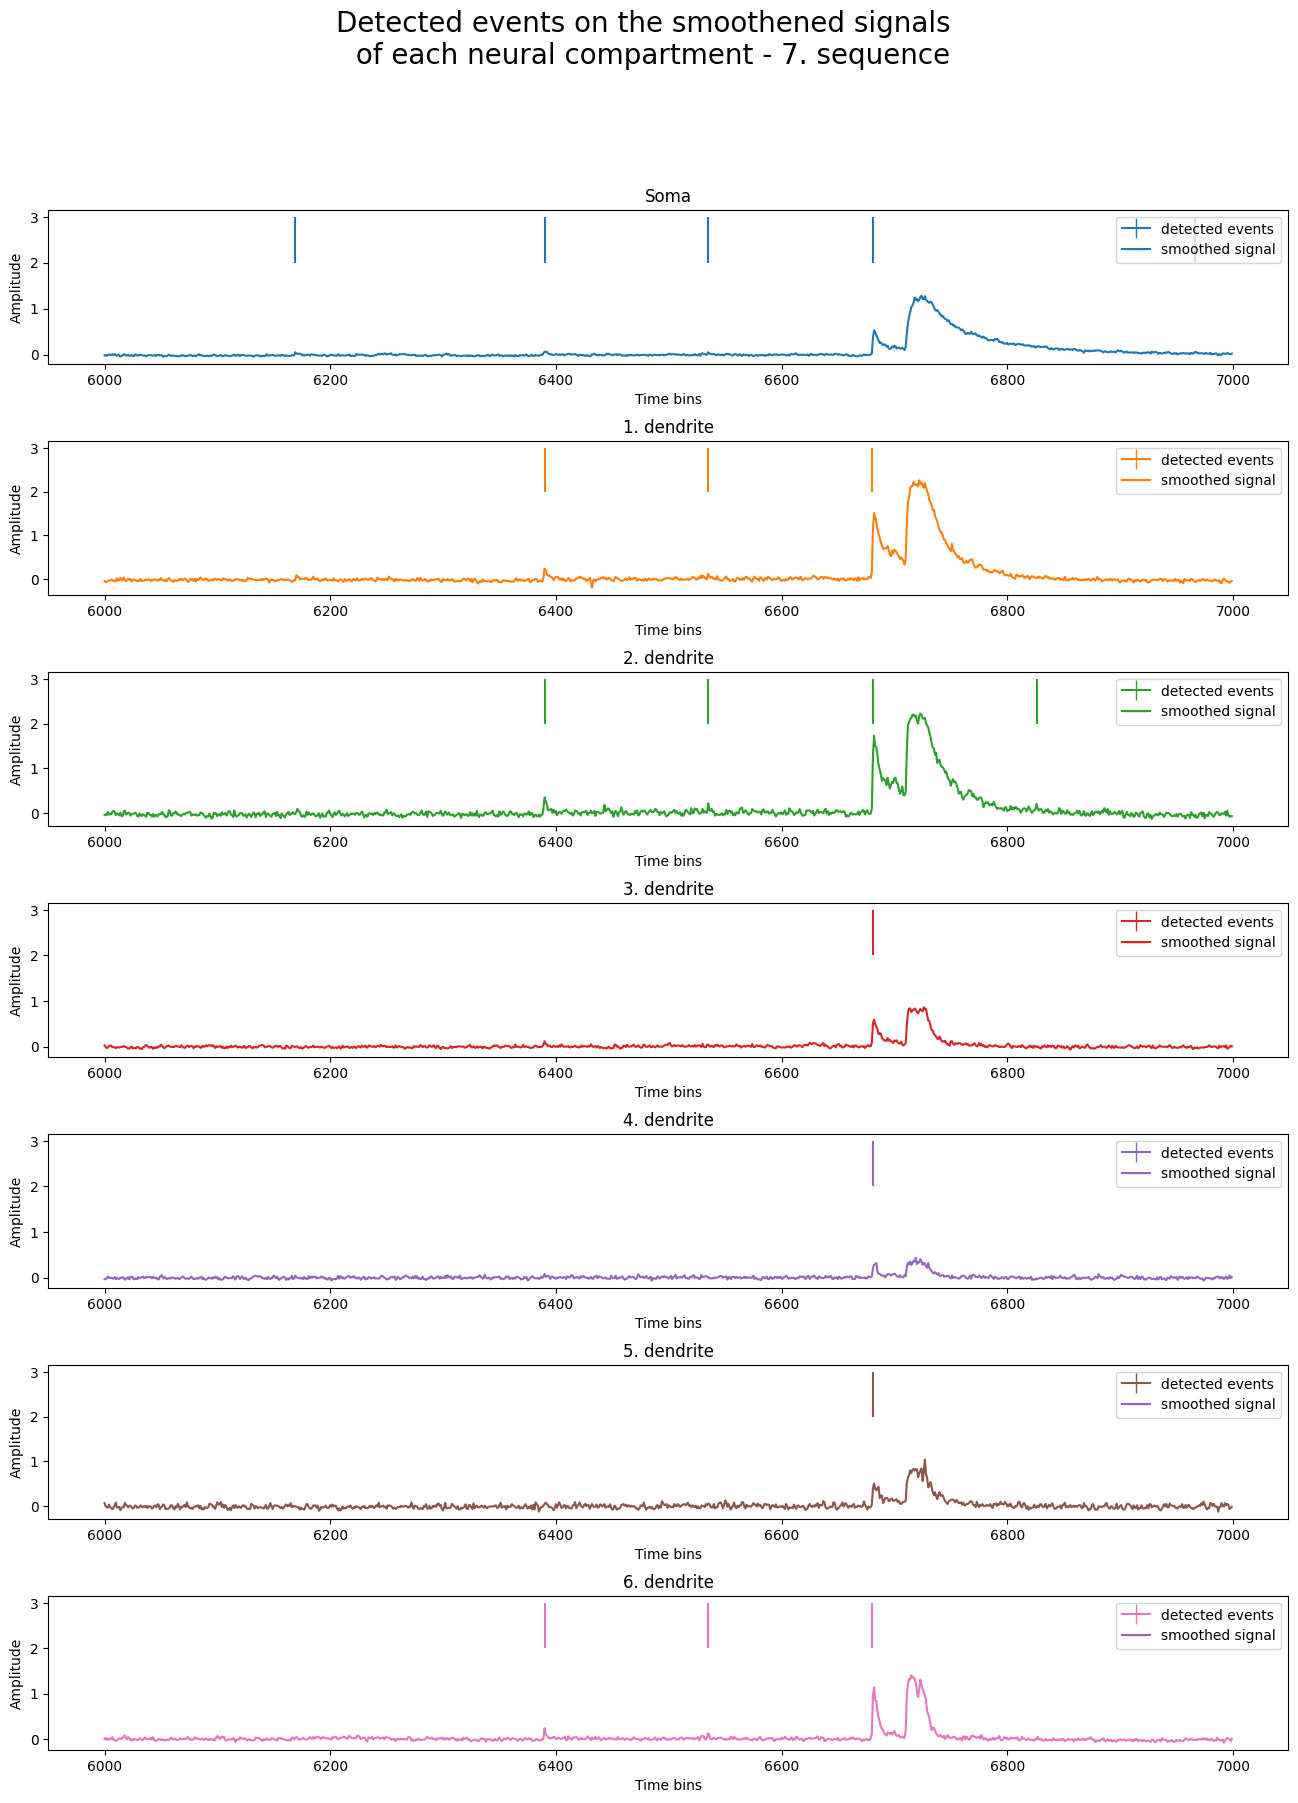

In [173]:
# Plotting the gauss smoothed signals:
import matplotlib.lines as mlines

fig, axs = plt.subplots(7, 1,figsize=(16,20))
plt.subplots_adjust(hspace=0.5)

axs[0].vlines(np.flatnonzero(sig1_event), 2, 3, color = colors[0])
axs[0].plot(signal1_smooth, color = colors[0])
axs[1].vlines(np.flatnonzero(sig2_event), 2, 3, color = colors[1])
axs[1].plot(signal2_smooth, color = colors[1])
axs[2].vlines(np.flatnonzero(sig3_event), 2, 3, color = colors[2])
axs[2].plot(signal3_smooth, color = colors[2])
axs[3].vlines(np.flatnonzero(sig4_event), 2, 3, color = colors[3])
axs[3].plot(signal4_smooth, color = colors[3])
axs[4].vlines(np.flatnonzero(sig5_event), 2, 3, color = colors[4])
axs[4].plot(signal5_smooth, color = colors[4])
axs[5].vlines(np.flatnonzero(sig6_event), 2, 3, color = colors[5])
axs[5].plot(signal6_smooth, color = colors[5])
axs[6].vlines(np.flatnonzero(sig7_event), 2, 3, color = colors[6])
axs[6].plot(signal7_smooth, color = colors[6])

axs[0].title.set_text('Soma')
axs[1].title.set_text('1. dendrite')
axs[2].title.set_text('2. dendrite')
axs[3].title.set_text('3. dendrite')
axs[4].title.set_text('4. dendrite')
axs[5].title.set_text('5. dendrite')
axs[6].title.set_text('6. dendrite')

axs[0].set_xlabel('Time bins')
axs[1].set_xlabel('Time bins')
axs[2].set_xlabel('Time bins')
axs[3].set_xlabel('Time bins')
axs[4].set_xlabel('Time bins')
axs[5].set_xlabel('Time bins')
axs[6].set_xlabel('Time bins')

axs[0].set_ylabel('Amplitude')
axs[1].set_ylabel('Amplitude')
axs[2].set_ylabel('Amplitude')
axs[3].set_ylabel('Amplitude')
axs[4].set_ylabel('Amplitude')
axs[5].set_ylabel('Amplitude')
axs[6].set_ylabel('Amplitude')

blue_lineV = mlines.Line2D([], [], color = colors[0], marker='|',
                          markersize=15, label='detected events')

orange_lineV = mlines.Line2D([], [], color = colors[1], marker='|',
                          markersize=15, label='detected events')

green_lineV = mlines.Line2D([], [], color = colors[2], marker='|',
                          markersize=15, label='detected events')

red_lineV = mlines.Line2D([], [], color = colors[3], marker='|',
                          markersize=15, label='detected events')

purple_lineV = mlines.Line2D([], [], color = colors[4], marker='|',
                          markersize=15, label='detected events')

brown_lineV = mlines.Line2D([], [], color = colors[5], marker='|',
                          markersize=15, label='detected events')

pink_lineV = mlines.Line2D([], [], color = colors[6], marker='|',
                          markersize=15, label='detected events')
#hlines

blue_lineH = mlines.Line2D([], [], color = colors[0], marker='_',
                          markersize=15, label='smoothed signal')

orange_lineH = mlines.Line2D([], [], color = colors[1], marker='_',
                          markersize=15, label='smoothed signal')

green_lineH = mlines.Line2D([], [], color = colors[2], marker='_',
                          markersize=15, label='smoothed signal')

red_lineH = mlines.Line2D([], [], color = colors[3], marker='_',
                          markersize=15, label='smoothed signal')

purple_lineH = mlines.Line2D([], [], color = colors[4], marker='_',
                          markersize=15, label='smoothed signal')

brown_lineH = mlines.Line2D([], [], color = colors[5], marker='_',
                          markersize=15, label='smoothed signal')

pink_lineH = mlines.Line2D([], [], color = colors[6], marker='_',
                          markersize=15, label='smoothed signal')

axs[0].legend(handles=[blue_lineV, blue_lineH], loc='upper right')
axs[1].legend(handles=[orange_lineV, orange_lineH], loc='upper right')
axs[2].legend(handles=[green_lineV, green_lineH], loc='upper right')
axs[3].legend(handles=[red_lineV, red_lineH], loc='upper right')
axs[4].legend(handles=[purple_lineV, purple_lineH], loc='upper right')
axs[5].legend(handles=[brown_lineV, purple_lineH], loc='upper right')
axs[6].legend(handles=[pink_lineV, purple_lineH], loc='upper right')

#ticks

w_seq = 6
thous = 1000 * w_seq
ex_ticks_lab = [0, 200, 400, 600, 800, 1000]
ex_ticks_lab = [i+thous for i in ex_ticks_lab]

axs[0].set_xticks([0, 200, 400, 600, 800, 1000],  ex_ticks_lab )
axs[1].set_xticks([0, 200, 400, 600, 800, 1000],  ex_ticks_lab )
axs[2].set_xticks([0, 200, 400, 600, 800, 1000],  ex_ticks_lab )
axs[3].set_xticks([0, 200, 400, 600, 800, 1000],  ex_ticks_lab )
axs[4].set_xticks([0, 200, 400, 600, 800, 1000],  ex_ticks_lab )
axs[5].set_xticks([0, 200, 400, 600, 800, 1000],  ex_ticks_lab )
axs[6].set_xticks([0, 200, 400, 600, 800, 1000],  ex_ticks_lab )

fig.suptitle('Detected events on the smoothened signals \n of each neural compartment - 7. sequence', fontsize=20)
plt.savefig('real_data/eighth.pdf', format = 'pdf')

Save the smoothed signals and the detected events:

In [175]:
s1 = np.save('real_data/Asmooth1', signal1_smooth)
s2 = np.save('real_data/Asmooth2', signal2_smooth)
s3 = np.save('real_data/Asmooth3', signal3_smooth)
s4 = np.save('real_data/Asmooth4', signal4_smooth)
s5 = np.save('real_data/Asmooth5', signal5_smooth)
s6 = np.save('real_data/Asmooth6', signal6_smooth)
s7 = np.save('real_data/Asmooth7', signal7_smooth)

e1 = np.save('real_data/Aevent1', sig1_event)
e2 = np.save('real_data/Aevent2', sig2_event)
e3 = np.save('real_data/Aevent3', sig3_event)
e4 = np.save('real_data/Aevent4', sig4_event)
e5 = np.save('real_data/Aevent5', sig5_event)
e6 = np.save('real_data/Aevent6', sig6_event)
e7 = np.save('real_data/Aevent7', sig7_event)